**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
# import cv2

**Loading the MNIST data and forming arrays of the normal training data and the test data (normal and abnormal)**

In [2]:
#yf_test=2 is shirts <- this is our base, shoes will be the anomaly
#yf_test=9 is shoes

#note* yf_test=3 is dresses
#note* yf_test=8 is purses

nl1 = 2
nl2 = 2
abn = 9

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

normal_data = x_train[(y_train == nl1) | (y_train == nl2)]    # Normal training data (Normal digitss)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2)]  

test_data = x_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2)]   # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
normal_data.shape, test_data.shape, test_labels.shape

((6000, 28, 28), (2000, 28, 28), (2000,))

In [4]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2)]   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                          # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2)]   # Their labels
abnormal_test_labels = test_labels[test_labels == abn]                          # Their labels

In [5]:
normal_test_data.shape, abnormal_test_data.shape

((1000, 28, 28), (1000, 28, 28))

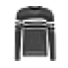

In [6]:
# First normal digit
plt.figure(figsize=(1,1))
plt.imshow(normal_data[0], cmap="binary")
plt.axis('off')
plt.show()

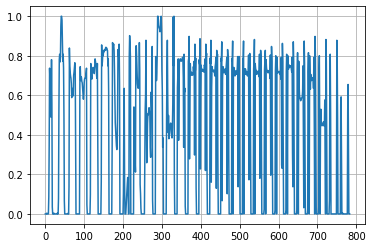

In [7]:
# 1 dim plot of (flattened array of) first normal digit
plt.grid()
plt.plot(np.arange(28*28), normal_data[0].ravel())
plt.show()

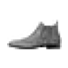

In [8]:
# first test digit
plt.figure(figsize=(1,1))
plt.imshow(test_data[0], cmap="binary")
plt.axis('off')
plt.show()

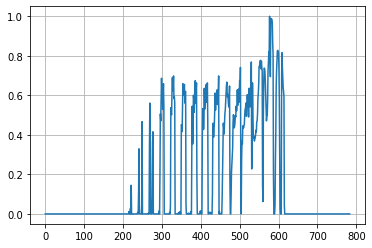

In [9]:
# 1 dim plot of first test digit
plt.grid()
plt.plot(np.arange(28*28), test_data[0].ravel())
plt.show()

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(32, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [12]:
history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
12/12 [==============================] - 2s 52ms/step - loss: 0.5903 - val_loss: 0.5468
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 0.4691 - val_loss: 0.5196
Epoch 3/100
12/12 [==============================] - 0s 35ms/step - loss: 0.4437 - val_loss: 0.5043
Epoch 4/100
12/12 [==============================] - 0s 36ms/step - loss: 0.4271 - val_loss: 0.5011
Epoch 5/100
12/12 [==============================] - 0s 35ms/step - loss: 0.4157 - val_loss: 0.5017
Epoch 6/100
12/12 [==============================] - 0s 35ms/step - loss: 0.4096 - val_loss: 0.4962
Epoch 7/100
12/12 [==============================] - 0s 37ms/step - loss: 0.4106 - val_loss: 0.4888
Epoch 8/100
12/12 [==============================] - 0s 37ms/step - loss: 0.4039 - val_loss: 0.4878
Epoch 9/100
12/12 [==============================] - 0s 36ms/step - loss: 0.4015 - val_loss: 0.4892
Epoch 10/100
12/12 [==============================] - 0s 35ms/step - loss: 0.3984 - val_loss: 0.5062

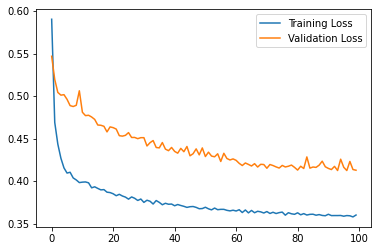

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

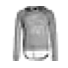

In [14]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(normal_test_data[1], cmap="binary")
plt.axis('off')
plt.show()

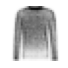

In [15]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_data[1], cmap="binary")
plt.axis('off')
plt.show()

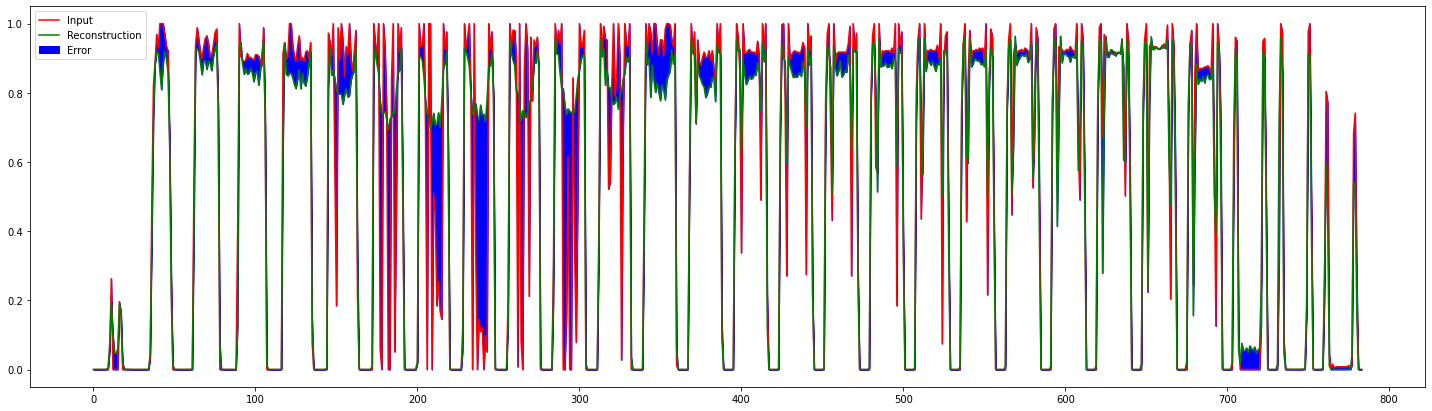

In [16]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

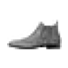

In [17]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

plt.figure(figsize=(1,1))
plt.imshow(abnormal_test_data[0], cmap="binary")
plt.axis('off')
plt.show()

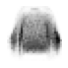

In [18]:
plt.figure(figsize=(1,1))
plt.imshow(decoded_abn_data[0], cmap="binary")
plt.axis('off')
plt.show()

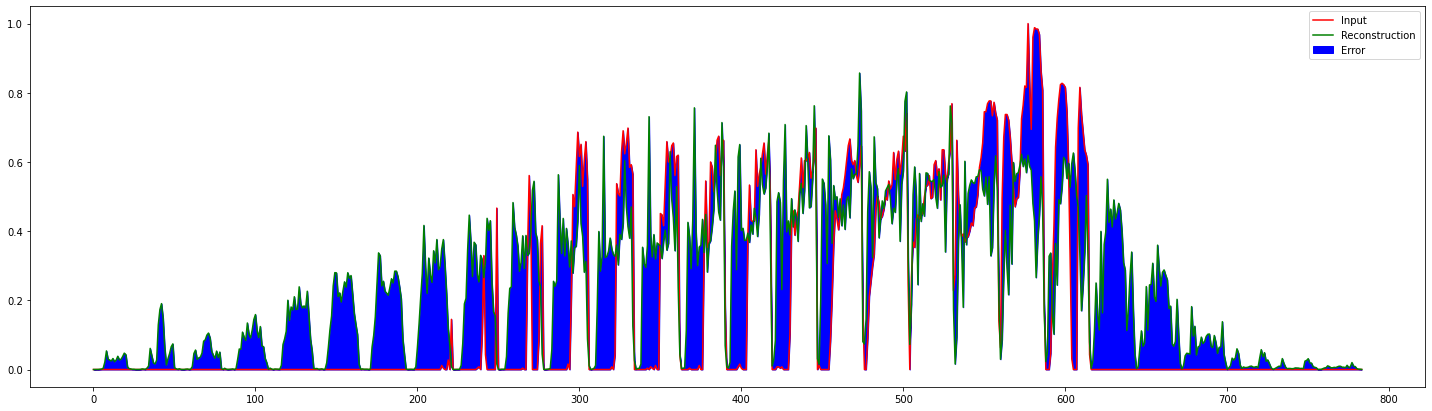

In [19]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Distribution of the reconstruction losses of the normal training data**

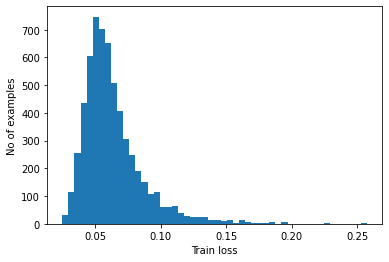

In [20]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [21]:
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))

Mean:  0.06357579
Std:  0.02363985


In [22]:
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold1: ", threshold1)

Threshold1:  0.12267541512846947


**Distribution of the reconstruction losses of the abnormal test data**

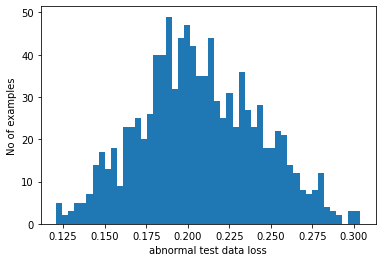

In [23]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))

plt.hist(abn_test_loss[None, :], bins=50)
plt.xlabel("abnormal test data loss")
plt.ylabel("No of examples")
plt.show()

In [24]:
# threshold2 = np.mean(abn_test_loss) - np.std(abn_test_loss)
# print("Threshold2: ", threshold2)

In [25]:
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.20684326, 0.035691097)

**Threshold will be threshold1 = mean + std of the distribution of the reconstruction losses of the normal training data**

In [26]:
threshold = threshold1

**Calculation of the confusion matrix**

In [27]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [28]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels_T_F)

Confusion Matrix: 
 prediction: F      T 
             1027   973
 label: F   [[997   3]    1000
        T    [30   970]]   1000
Accuracy = 0.9835
Precision = 0.9969167523124358
Recall = 0.97


In [29]:
print(confusion_matrix(test_labels_T_F, preds))

[[997   3]
 [ 30 970]]


**Distribution of the reconstruction losses of the test data (normal and abnormal)**

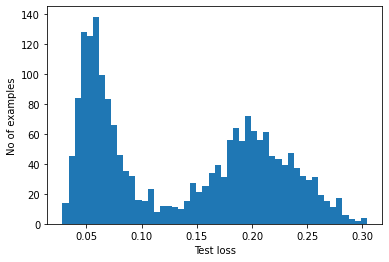

In [30]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()